Finish initialising class black_sea_obj


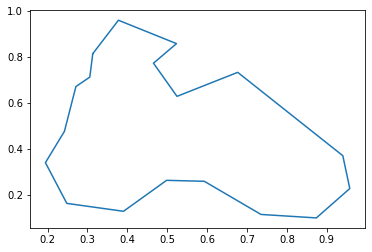

Finish initialising class black_sea_obj
Finish initialising class black_sea_obj


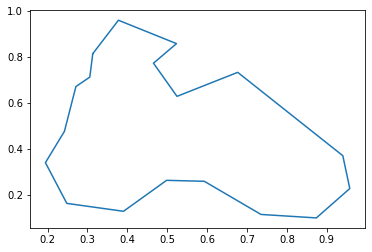

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #; sns.set_theme() # For heat map
from scipy.optimize import minimize # For automatic minimisation of the negative
# likelihood of the position
import numpy.random as rnd
import numpy.linalg as linalg
import matplotlib.path as mpltPath # to check if the point is on the border
from scipy.optimize import NonlinearConstraint
from ipynb.fs.full.class_virt_sensor import virt_sensor_net2
from ipynb.fs.full.class_ship import ship_fleet
from ipynb.fs.full.class_black_sea import black_sea_obj
%run ./strand2_methods.ipynb
%run ./class_black_sea.ipynb

<IPython.core.display.Javascript object>


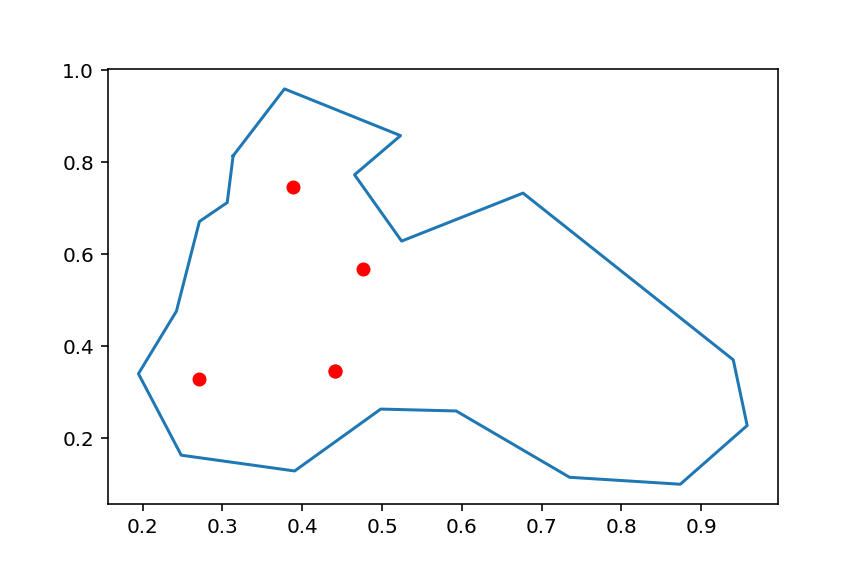

In [32]:
# TEST: Function that adds high utility and cost regions 

%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])

#text=ax.text(0,0, "", va="bottom", ha="left")
def onclick(event):
    global ix, iy
    ix, iy = event.xdata, event.ydata
    
    # Print the clicked values
    vals = "x = %d, y = %d" % (ix, iy)
    print(vals)
    
    # Plot the clicked values
    ax = plt.gcf().gca()
    ax.plot(ix, iy, 'ro')
    
    # assign global variable to access outside of function
    global coords
    coords.append((ix, iy))
    
    
    
    '''
    # Disconnect after 2 clicks
    if len(coords) == 2:
        fig.canvas.mpl_disconnect(cid)
        #plt.close(1)
    return
    '''
    


coords = []

# Call click func
cid = fig.canvas.mpl_connect('button_press_event', onclick)


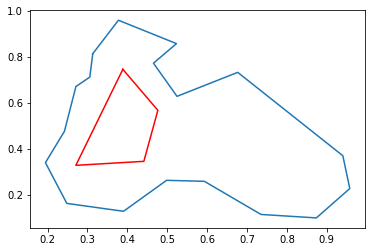

In [33]:
# print coords
%matplotlib inline

high_utility_region = np.array(coords)
# add first point
first = high_utility_region[0]
high_utility_region = np.vstack([high_utility_region, first])
plt.figure()
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.plot(high_utility_region[:,0], high_utility_region[:,1], 'r-')
#print(high_utility_region)

Finish initialising class black_sea_obj
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.003425735363630095
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9
The average MSE over all lanes and repetitions is: 0.3787383350226032
The average MSE over all lanes and repetitions is: 0.4306409840379857
0.009151507813001804


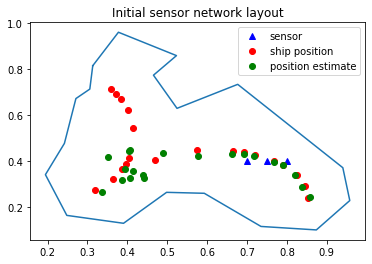

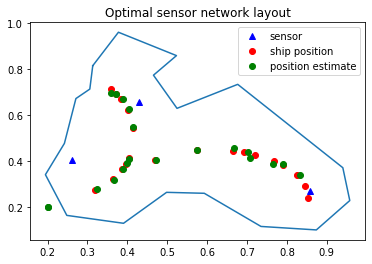

In [2]:
# MAIN SCRIPT ###############################



# Need to define the black sea object globally before loading the methods
black_sea_coords = np.load('blackSea_polygon_coords.npy')
global black_sea
black_sea = black_sea_obj(black_sea_coords)



# Setting istanbul at lower left corner (but let the method decide the concrete point
# by setting it as [0,0] (outside of area))
#black_sea.set_port('Istanbul', np.array([0,0]))


# Config

num_rep = 10 # Number of times each ship lane is repeated to obtain a mean prediction
global time_stop
time_stop = 10 # Time horizon for the ship movement
m = 3 # Number of sensors

# Define ships and their lanes by hand
ship_coords = np.array([.25, .3, .4, .55]).reshape(2,2)
ship_velocities = np.array([.02, .02, .04, 0]).reshape(2,2)
global fleet
fleet = ship_fleet(ship_coords, ship_velocities, np.zeros(len(ship_coords)))

# Virtual sensor errors
err_mean = .05 # This error is the multiplicative value k in
# k*log(true_distance), and is used to define the standard deviation of a random 
# draw from N(0, k*log(true_distance)) that is added to the true_distance of a
# sensor to the ship
err_stdev = .5



# TESTING BFGS/SLSQP implementations

nlc = NonlinearConstraint(within_borders, 0, np.inf) # first argument is the
# contraint f(x) while second and third argument define c_1 < f(x) < c_2 where
# +-np.inf is a valid optim; IDEA FOR IMPLEMENTATION: give +-1 if it is (outside)
# within borders and use "0, np.inf" as arguments

# Fixed initial network
sensor_coords_0 = np.array([.75, .4, .7, .4, .8, .4]) # TRIAL as vector implementation
# NOTE: The bounds are used to concentrate the optimisation further into the relevant area for
# quicker convergence; the non-linear constraint (nlc) defines the actual borders
bnds = (((0,1),) * 2*m) # Need to define 2m bounds for each element of the variable vector
# NOTE: 'ftol' is the termination tolerance w.r.t. the gradient at the points (since we want to minimise)
res = minimize(MSE_loss, sensor_coords_0, method = 'SLSQP', jac = pseudo_MSE_loss_gradient,
               bounds = bnds, constraints = nlc, options={'ftol': 1e-10, 'maxiter': 200, 'disp': True})
opt_sensor_coords = res.x


# TESTING COBYLA
# NOTE: COBYLA does not use the jacobian
'''
res = minimize(MSE_loss, sensor_coords_0, method = 'COBYLA', jac = pseudo_MSE_loss_gradient,
               bounds = bnds, constraints = nlc, options={'tol': 1e-4, 'maxfev': 200, 'disp': True})
'''

    
    
# TESTING implementation with BFGS algorithm

#sensor_coords_0 = rnd.uniform(.1, .4, size = (2*m)) # TRIAL as vector implementation

# Fixed initial network
'''
sensor_coords_0 = np.array([.4, .4, .7, .4, .8, .4]) # TRIAL as vector implementation
res = minimize(MSE_loss, sensor_coords_0, method = 'BFGS', jac = pseudo_MSE_loss_gradient,
               options={'gtol': 1e-4, 'disp': True})
opt_sensor_coords = res.x
'''


# OLD VERSION: Sensor placement using Nelder-Mead
'''
# Gradient descent method for sensor placement
sensor_coords_0 = rnd.uniform(10,40,(m,2)) # Random first sensor placements
res = minimize(MSE_loss, sensor_coords_0, method='nelder-mead', 
               options={'disp': True})
opt_sensor_coords = res.x
'''




# First we plot the initial sensor placement and their mean predictions, followed
# by the "optimal placement" according to Nelson-Mead method w.r.t. MLE loss
# minimisation

# Testing BFGS/SLSQP implementations
MSE_loss_plot(sensor_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Initial sensor network layout")
MSE_loss_plot(opt_sensor_coords)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Optimal sensor network layout")


# FOR DEBUGGING: (Problem: SLSQP reported function value is very different that presented one)
print(MSE_loss(opt_sensor_coords))
# ANSWER: No problem in the code BUT rather the random gaussians that give the position estimates

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.28527051957573957
            Iterations: 4
            Function evaluations: 26
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3243160209867022
            Iterations: 7
            Function evaluations: 45
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.029615726780508785
            Iterations: 16
            Function evaluations: 106
            Gradient evaluations: 16
Iteration limit reached    (Exit mode 9)
            Current function value: 0.0027550971553968505
            Iterations: 200
            Function evaluations: 265
            Gradient evaluations: 73
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.005074785399351733
            Iterations: 7
            Function evaluation

Text(0.5, 1.0, 'Best number optimal sensor network layout')

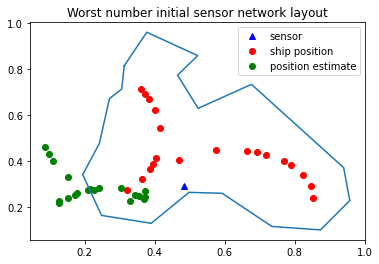

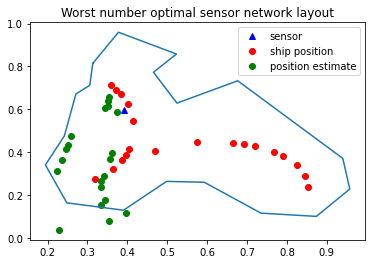

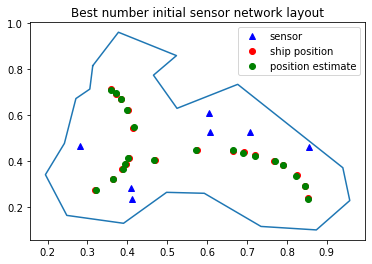

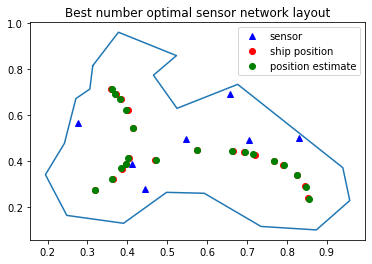

In [3]:
# TESTING optimal number of sensor placements

'''
# Define black sea object
black_sea_coords = np.load('/Users/marcelstozir/Desktop/IRP_sensorOptimisation/actual_work/code/simulation_of_simplified_sound_measures/definition_of_black_sea_borders/blackSea_polygon_coords.npy')
#plt.plot(black_sea_coords[:,0], black_sea_coords[:,1],'o')

black_sea = black_sea_obj(black_sea_coords)

# Setting istanbul at lower left corner (but let the method decide the concrete point
# by setting it as [0,0] (outside of area))
black_sea.set_port('Istanbul', np.array([0,0]))
'''


num_rep = 10 # Number of times each ship lane is repeated to obtain a mean prediction
time_stop = 10 # Time horizon for the ship movement

# Define ships and their lanes by hand
ship_coords = np.array([.25, .3, .4, .55]).reshape(2,2)
ship_velocities = np.array([.02, .02, .04, 0]).reshape(2,2)
fleet = ship_fleet(ship_coords, ship_velocities, np.zeros(len(ship_coords)))

# Virtual sensor errors
err_mean = .05 # This error is the multiplicative value k in
# k*log(true_distance), and is used to define the standard deviation of a random 
# draw from N(0, k*log(true_distance)) that is added to the true_distance of a
# sensor to the ship
err_stdev = .5


nlc = NonlinearConstraint(within_borders, 0, np.inf) # first argument is the
# contraint f(x) while second and third argument define c_1 < f(x) < c_2 where
# +-np.inf is a valid optim; IDEA FOR IMPLEMENTATION: give +-1 if it is (outside)
# within borders and use "0, np.inf" as arguments

best_number, worst_number, log_book = get_optimal_sensor_number(10)



# PLOT

# Testing optimal number of sensors

# Worst number; initial and optimal plot
m = worst_number
worst_coords_0 = log_book[0][worst_number - 1]
worst_coords_opt = log_book[1][worst_number - 1]
MSE_loss_plot(worst_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number initial sensor network layout")
MSE_loss_plot(worst_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Worst number optimal sensor network layout")

# Best number; initial and optimal plot
m = best_number
best_coords_0 = log_book[0][best_number - 1]
best_coords_opt = log_book[1][best_number - 1]
MSE_loss_plot(best_coords_0)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number initial sensor network layout")
MSE_loss_plot(best_coords_opt)
ax = plt.gcf().gca()
ax.plot(black_sea.border_points[:,0],black_sea.border_points[:,1])
ax.set_title("Best number optimal sensor network layout")

In [ ]:
# IMPORTANT NOTE FOR MEETING: Based on the documentation of SLSQP the constraint (as well as the objective function) 
# need to be square differentiable; It sometimes occured that because of the +-1 classification, the optimiser
# does not respect the boundaries. SUGGESTION: Instead of checking if a point is in the shape, we can measure
# it's distance to it (where =0 if it is inside or on the boundary) such that e.g. the SIGMOID function can be
# used for a smooth transition (although it would allow for non-sharp borders)